In [49]:
import numpy as np
import math
import matplotlib.pyplot as plt

In [50]:

#--------------------****Rienman Solver****------------------------------------------------------------------------------------- 

def riemann_solver(primitive_left, primitive_right, gamma_gas, gas_constant, x_initial, x_range, time_initial, time_location,nx):
    

    ## Function to calculate shock wave function
    def shock_fun(p_initial, density, pressure, gamma,sound_speed):
    
        numerator = 2 / ((gamma + 1) * density)
        denominator = p_initial + (((gamma - 1) / (gamma + 1)) * pressure)
        ratio = np.sqrt(numerator / denominator)
        return ((p_initial - pressure) * ratio)

    ## Function to calculate expansion fan function
    def expansion_fun(p_initial, density, pressure, gamma, sound_speed):
        power = (gamma - 1) / (2 * gamma)
        multiply = (2 * sound_speed) / (gamma - 1)
        p_ratio = p_initial / pressure
        return (multiply * ((p_ratio ** power) - 1))

    ## Function to calculate shock wave differential function
    def shock_diff(p_initial, density, pressure, gamma, sound_speed):
        numerator = 2 / ((gamma + 1) * density)
        denominator = p_initial + (((gamma - 1) / (gamma + 1)) * pressure)
        ratio = np.sqrt(numerator / denominator)
        num1 = p_initial - pressure
        deno1 = 2 * denominator
        return (ratio * (1 - (num1 / deno1)))
    
    ## Function to calculate expansion fan differential function
    def expansion_diff_fun(p_initial, density, pressure, gamma, sound_speed):
        power = -((gamma + 1) / (2 * gamma))
        p_ratio = p_initial / pressure
        return ((1 / (density * sound_speed)) * (p_ratio ** power))
    
    ## Function to calculate pressure and density at the contact surface location
    def contact_condition(pressure_star, density_right, velocity_right, pressure_right, gamma_right, sound_speed_right, density_left, \
                      velocity_left, pressure_left, gamma_left, sound_speed_left, tol):
        error = 10
        # to check if the pressure is less than zero and assign 0.001 if it is--
        if pressure_star < 0:  
            pressure_star = 1e-3
        while error > tol:
            
            # to define which function one have to used, based on one's location
            if pressure_star > pressure_left:
                fun_left = shock_fun(pressure_star, density_left, pressure_left, gamma_left,sound_speed_left)
                fun_diff_left = shock_diff(pressure_star, density_left, pressure_left, gamma_left,sound_speed_left)
            else:
                fun_left = expansion_fun(pressure_star, density_left, pressure_left, gamma_left,sound_speed_left)
                fun_diff_left = expansion_diff_fun(pressure_star, density_left, pressure_left, gamma_left,sound_speed_left)
            
            if pressure_star > pressure_right:
                fun_right = shock_fun(pressure_star, density_right, pressure_right, gamma_right,sound_speed_right)
                fun_diff_right = shock_diff(pressure_star, density_right, pressure_right, gamma_right,sound_speed_right)
            else:
                fun_right = expansion_fun(pressure_star, density_right, pressure_right, gamma_right,sound_speed_right)
                fun_diff_right = expansion_diff_fun(pressure_star, density_right, pressure_right, gamma_right,sound_speed_right)

            # calculates the pressure fun
            pressure_fun = fun_left + fun_right + (velocity_right - velocity_left)
            
            # calculates the pressure differentiation function
            pressure_diff_fun = fun_diff_left + fun_diff_right

            # Netwon's method to find out the exact pressure
            pressure_new = pressure_star - (pressure_fun / pressure_diff_fun)

            # error to check the convergence of the newton's method
            error = np.abs(pressure_new - pressure_star )/pressure_star
            if (pressure_new < 0):
                pressure_star = 1e-3
            else:
                pressure_star = pressure_new
       
        # calculate the velocity star at the contact surface
        velocity_star = 0.5 * (velocity_left + velocity_right) + (0.5 * (fun_right - fun_left))
        return pressure_new, velocity_star

    # Input parameters-------------------------------------------------------------
    gamma_left, gamma_right = gamma_gas  # gamma of the gas on left and right
    gas_constant_left, gas_constant_right = gas_constant # gas constant 
    
    # density, velocity, and pressure
    density_left, velocity_left, pressure_left = primitive_left # density, velocity and pressure
    density_right, velocity_right, pressure_right = primitive_right

    # temperature calculation
    temperature_left = pressure_left / (gas_constant_left * density_left)
    temperature_right = pressure_right / (gas_constant_right * density_right)
    
    # speed of sound calculation
    sound_speed_left = np.sqrt((gamma_left * pressure_left)/ density_left)
    sound_speed_right = np.sqrt((gamma_right * pressure_right)/ density_right)

    # Checking if there is a vacuum condition -------------------------------------------------------------------
    if ((velocity_right - velocity_left) >= (2/((gamma_left)-1)*(sound_speed_left + sound_speed_right))):
        raise ValueError("The given conditions will produce vacuum inside and this code is not made to handle those conditions")
        
    # tolrance value for the Newton method to solve the pressure and velocity at the contact surface
    tol = 1e-6  

    # Acoustic solution approximation to find pressure_star_initial ---------------------------------------------------------------------
    numerator_acoustic = (pressure_left * density_right * sound_speed_right) + (pressure_right * density_left * sound_speed_left)  \
                        + ((velocity_left - velocity_right) * (density_left * sound_speed_left * density_right * sound_speed_right))
    denominator_acoustic = (density_right * sound_speed_right) + (density_left * sound_speed_left)

    pressure_star = numerator_acoustic / denominator_acoustic

    # Finding the actual pressure and velocity star conditions at the contact surface
    # The function return the pressure and velocity values near the contact surface region
    p_actual, u_actual = contact_condition(pressure_star, density_right, velocity_right, pressure_right, gamma_right, \
                                           sound_speed_right, density_left, velocity_left, pressure_left, gamma_left, sound_speed_left, tol)

    #*****************************************************************************************#
    # Solution for the xt plot
    x_location = np.linspace(x_range[0], x_range[1], nx+5)
    
    
    velocity_star = u_actual
    pressure_star = p_actual
    '''
    # Contact surface - velocity line plotting
    if (velocity_star != 0):
        cs_t = (x_location - x_initial)/velocity_star
        plt.plot(x_location, cs_t, linestyle = 'dashdot', label = 'Contact surface')
    else:
        plt.axvline(x=0, linestyle='--',label = 'Contact surface')
    '''
    #For the left expansion wave-----------------------------------------------
    if pressure_star <= pressure_left: # we get left expansion wave 
        density_star_left = density_left*((pressure_star/pressure_left)**(1/gamma_left))
        
        # sound speed star left side 
        sound_star_left = sound_speed_left*((pressure_star/pressure_left)**((gamma_left-1)/(2*gamma_left)))
        
        # speed of head and tail of expansion wave
        speed_head_left = velocity_left - sound_speed_left
        speed_tail_left = velocity_star - sound_star_left

        # location of expansion head left
        exHeadLeft = (x_location - x_initial)/speed_head_left

        # location of the expansion tail eft
        exTailLeft = (x_location - x_initial)/speed_tail_left
        '''
        # plotting the expansion head and tail
        plt.plot(x_location, exHeadLeft, label = 'Expansion wave head - left')
        plt.plot(x_location, exTailLeft, label = 'Expansion wave tail - left')
        '''
 
    else:
        # we have a left shock wave --------------------------
        pressure_ratio_left = pressure_star/pressure_left
    
        # shock speed calculation
        shock_mach_left = np.sqrt(((pressure_ratio_left*(gamma_left+1)) + (gamma_left - 1))/(2*gamma_left))

        # calculation of the shock speed on left side
        shock_speed_left = velocity_left - (sound_speed_left*shock_mach_left)

        # calculation of the location of left shock
        shLeft = (x_location - x_initial)/shock_speed_left

        '''
        # plotting the left shock
        plt.plot(x_location, shLeft, label = 'Left facing Shock')
        '''
        
    #else:
    # Finding the values in the RIGHT side ---------------------------------
    if pressure_star <= pressure_right: # we get right expansion wave
        density_star_right =density_right*((pressure_star/pressure_right)**(1/gamma_right))
        # sound speed star right side 
        sound_star_right =sound_speed_right*((pressure_star/pressure_right)**((gamma_right - 1)/(2*gamma_right)))

         # speed of head and tail of expansion wave
        speed_head_right = velocity_right + sound_speed_right
        speed_tail_right = velocity_star + sound_star_right
        
        # location of expansion head right
        exHeadRight = (x_location - x_initial)/speed_head_right

        # location of expansion tail right
        exTailRight = (x_location - x_initial)/speed_tail_right
        
        '''
        # plotting the expansion head and tail
        plt.plot(x_location, exHeadRight, label = 'Expansion wave head - right')
        plt.plot(x_location, exTailRight, label = 'Expansion wave tail - right')
        '''
    
        
    else:  # we get right shock wave (pressure_star > pressure_left)
        pressure_ratio_right = pressure_star/pressure_right
        shock_mach_right = np.sqrt(((pressure_ratio_right*(gamma_right+1))+ (gamma_right - 1))/(2*gamma_right))
        shock_speed_right = velocity_right + (sound_speed_right*shock_mach_right)
    
        shRight = (x_location - x_initial)/shock_speed_right
        '''
        plt.plot(x_location, shRight, label = 'Right facing Shock')
        '''
    '''
    plt.ylim(0,time_location*5)
    plt.xlim(x_range[0],x_range[1])
    plt.xlabel('X-coordinate')
    plt.ylabel('Time')
    plt.grid(True)
    plt.minorticks_on()
    plt.title('X-T Diagram')
    plt.legend(loc='upper left')
    # Saving the figure
    #plt.savefig('Problem_1_xt_dig.png', dpi = 300)
    plt.show()
    '''
    ## Calculation of density, velocity, and pressure at all locations, at a given time interval ----------
    x_values = []
    density_location = []
    velocity_location = []
    pressure_location = []
    
     
    for i in range(len(x_location)):
        x = x_location[i]
        xt_ratio = (x - x_initial) / (time_location - time_initial)  # to find x/t ratio
        if xt_ratio <= velocity_star:
            if (pressure_star <= pressure_left): # we get left expansion wave
                if (xt_ratio < speed_head_left):  # we are in the right of left head expansion wave
                    density_location.append(density_left)
                    velocity_location.append(velocity_left)
                    pressure_location.append(pressure_left)

                elif (xt_ratio > speed_tail_left): # we are in the left of left tail expansion wave
                    density_location.append(density_star_left)
                    velocity_location.append(velocity_star)
                    pressure_location.append(pressure_star)
                else:  # we are in the centre of the left expansion wave
                    velocity_inside_left = (2/(gamma_left + 1))*(sound_speed_left + (((gamma_left - 1)/2)*velocity_left) + xt_ratio)
                    
                    # For pressure there are two many variables, so we will break terms
                    p_2_left = velocity_left - xt_ratio
                    p_1_left = ((gamma_left - 1)/(gamma_left + 1))*(1/sound_speed_left)
                    p_power_left = (2*gamma_left)/(gamma_left - 1)
                    pressure_inside_left = pressure_left*((2/(gamma_left + 1)) + (p_1_left*p_2_left))**p_power_left;
                    density_inside_left = density_left* ((2/(gamma_left + 1)) +(p_1_left*p_2_left))**(2/(gamma_left - 1))
    
                    density_location.append(density_inside_left)
                    velocity_location.append(velocity_inside_left)
                    pressure_location.append(pressure_inside_left)
            else:  # we get left shock wave
                if xt_ratio < shock_speed_left:  # we are in the right of left shock wave
                    density_location.append(density_left)
                    velocity_location.append(velocity_left)
                    pressure_location.append(pressure_left)
                else:  # we are in the left of left shock wave
                    # since density is a huge term, we will break it down
                    num_den_1 = pressure_ratio_left + ((gamma_left-1)/(gamma_left+1))
                    deno_den_1 = (((gamma_left-1)/(gamma_left+1))*pressure_ratio_left) + 1
                    density_star_left = density_left*(num_den_1/deno_den_1)
                    
                    density_location.append(density_star_left)
                    velocity_location.append(velocity_star)
                    pressure_location.append(pressure_star)
        else: 
            if (pressure_star <= pressure_right):  # we get right expansion wave
                if (xt_ratio > speed_head_right):  # we are in the right of right head expansion wave
                    density_location.append(density_right)
                    velocity_location.append(velocity_right)
                    pressure_location.append(pressure_right)

                elif (xt_ratio < speed_tail_right): # we are in the left of right tail expansion wave
                    density_location.append(density_star_right)
                    velocity_location.append(velocity_star)
                    pressure_location.append(pressure_star)
                else:  # we are in the centre of right expansion wave
                    
                    # Finding the variable values inside the expansion wave based 
                    # on the location --  x_location(i)/time
                    velocity_inside_right = (2/(gamma_right + 1))*(-sound_speed_right + (((gamma_right - 1)/2)*velocity_right)+ xt_ratio)
                    
                    # for pressure there are two many variables, so we will break terms
                    p_2_right = velocity_right - xt_ratio;
                    p_1_right = ((gamma_right - 1)/(gamma_right + 1))*(1/sound_speed_right)
                    p_power_right = (2*gamma_right)/(gamma_right - 1)
                    pressure_inside_right = pressure_right*((2/(gamma_right + 1)) - (p_1_right*p_2_right))**p_power_right
                    
                    density_inside_right = density_right* ((2/(gamma_right + 1)) -(p_1_right*p_2_right))**(2/(gamma_right - 1))
    
                    density_location.append(density_inside_right)
                    velocity_location.append(velocity_inside_right)
                    pressure_location.append(pressure_inside_right)
            else: # we get right shock wave
                if xt_ratio > shock_speed_right:  # we are in the right side of right shock wave
                    density_location.append(density_right)
                    velocity_location.append(velocity_right)
                    pressure_location.append(pressure_right)
                else:  # we are in the left side of right shock wave
                    
                    # since density is a huge term, we will break it down
                    num_den_2 = pressure_ratio_right + ((gamma_right - 1)/(gamma_right + 1))
                    deno_den_2 = (((gamma_right - 1)/(gamma_right + 1)) * pressure_ratio_right) + 1
                    density_star_right = density_right*(num_den_2/deno_den_2)
                    
                    density_location.append(density_star_right)
                    velocity_location.append(velocity_star)
                    pressure_location.append(pressure_star)

        if (x_location[i] == 0):
            
            w_final = [0,0,0]
            w_final[0] = density_location[i]
            w_final[1] = velocity_location[i]
            w_final[2] = pressure_location[i]


    return w_final


In [51]:
def conserve(U,W,g):
    
    for i in range(len(W)):
        
        U[i][0] = W[i][0]
        U[i][1] = W[i][0]*W[i][1]
        U[i][2] = (W[i][2]/(g-1)) + ((W[i][0]*W[i][1]**2)*0.5)
    return U

def flux(w,g,w_left):
    F = [0,0,0]
    for j in range(len(w_left)):
        if j == 0:
            F[j] = w[j]*w[j+1] 
        if j == 1:
            F[j] = (w[j-1]*w[j]**2) +  w[j+1] 
        if j == 2:
            rho_e = (w[j]/(g-1)) + ((w[j-2]*w[j-1]**2)*0.5)
            F[j] = (rho_e + w[j]) * w[j-1]
    return F


def primitive(U,W,g,x):
    
    for i in range(2,len(x)-2):
        
        W[i][0] = U[i][0]
        W[i][1] = U[i][1]/U[i][0]
        W[i][2] = (U[i][2] - ((U[i][1]**2)/(2*U[i][0])))*(g-1)
    return W

def ghost_add(W):
    W[0][0], W[0][1], W[0][2] = W[4][0], -W[4][1], W[4][2]
    W[1][0], W[1][1], W[1][2] = W[3][0], -W[3][1], W[3][2]

    W[-1][0], W[-1][1], W[-1][2] = W[-5][0], -W[-5][1], W[-5][2]
    W[-2][0], W[-2][1], W[-2][2] = W[-4][0], -W[-4][1], W[-4][2]
    return W

def boundary_add(W):
    W[2][1] = 0
    W[-3][1] = 0
    return W


def dW_limiter(W,x,w_left,b,dW):
    
    for i in range(2,len(x)-2):
        for j in range(len(w_left)):
            if (W[i+1][j] > W[i][j]):
                dW[i][j] = max(0, min((b*(W[i][j]-W[i-1][j])),(W[i+1][j]-W[i][j])), min((W[i][j]-W[i-1][j]), (b*(W[i+1][j]-W[i][j]))))
            elif(W[i+1][j] < W[i][j]):
                dW[i][j] = min(0, max((b*(W[i][j]-W[i-1][j])),(W[i+1][j]-W[i][j])), max((W[i][j]-W[i-1][j]), (b*(W[i+1][j]-W[i][j]))))
    
    dW[0], dW[1] = 0,0
    dW[-1], dW[-2] = 0,0

    return dW
'''
def dW_limiter(W,x,w_left,b,dW):
    
    dW[i] = 0

    return dW
'''
# Predictor function definition
def predictor(U,W,g,x,lamda,w_left,dW,U_pre):
    
    for i in range(2,len(x)-2):
    
        w_l = W[i] + 0.5*dW[i]
        w_r = W[i] - 0.5*dW[i]
        
        F_L = flux(w_l,g,w_left)
        F_R = flux(w_r,g,w_left)

        for j in range(len(w_left)):
            U_pre[i][j] = U[i][j] - (lamda*(F_L[j] - F_R[j]))
        
    return U_pre
# Corrector function definition
def corrector(Un,W_pre,W,lamda,x,dt,g,w_left,dW,x_range,nx):
    
    U = Un.copy()
    
    gamma = [1.4, 1.4]  # gamma_left, gamma_right
    r_gas = [287, 287]  # gas_constant_left, gas_constant_right
    t_in= 0.0
    x_in = 0.0
    
    for i in range(2,len(x)-2):
    
        w_l_p =  0.5*(W[i] + W_pre[i]) + 0.5*dW[i]
        w_r_p =  0.5*(W[i+1] + W_pre[i+1]) - 0.5*dW[i+1]
        w_RS_p = riemann_solver(w_l_p, w_r_p, gamma, r_gas, x_in, x_range, t_in, dt,nx)
        #print(w_RS_p)
        F_L = flux(w_RS_p,g,w_left)
        
        w_l_m =  0.5*(W[i-1] + W_pre[i-1]) + 0.5*dW[i-1]
        w_r_m =  0.5*(W[i] + W_pre[i]) - 0.5*dW[i]
        w_RS_m = riemann_solver(w_l_m, w_r_m, gamma, r_gas, x_in, x_range, t_in, dt,nx)
        F_R = flux(w_RS_m,g,w_left)

        for j in range(len(w_left)):
            U[i][j] = Un[i][j] - (lamda*(F_L[j] - F_R[j]))
    
    return U
    

In [52]:

nt = 500

t_f, t_i = 0.5, 0
dt = (t_f-t_i)/nt

x_f, x_i = 1.5, 0
nx = 150
#nx_refine = [150,300,450]
dx = (x_f-x_i)/nx
x = np.linspace(x_i-2*dx, x_f+2*dx, nx+5)

time = np.linspace(t_i, t_f, nt+1)
lamda = dt/dx
w_left = [100,0,1000]
w_right = [1,0,1]
g = [1.4,1.4]

gamma = 1.4
W = np.zeros((len(x),3))
U = np.zeros((len(x),3))

x_range = [x_i-2*dx,x_f+2*dx]
for i in range(len(x)):  
    
    if x[i] >=0 and x[i]<= 0.1:
        for j in range(len(w_left)):
            W[i][j] = w_left[j]

    if x[i] > 0.1 and x[i] <= 1.5:
        for j in range(len(w_right)):
            W[i][j] = w_right[j]

W = ghost_add(W)
U = conserve(U,W,gamma)


In [53]:

U_pre = np.zeros((len(x), 3))
W_pre = np.zeros_like(W)
dW = np.zeros_like(W)
w_plot = np.zeros((len(time), len(x), 3))


In [54]:

b = 2
   
for n,t in enumerate(time[1:]):
    Un = U.copy()
    Wn = W.copy()
    
    dW = dW_limiter(W,x,w_left,b,dW)
    
    U_pre = predictor(U,W,gamma,x,lamda,w_left,dW,U_pre)
    W_pre = primitive(U_pre,W_pre,gamma,x)
    W_pre = ghost_add(W_pre)
    W_pre = boundary_add(W_pre)
    
    U = corrector(Un,W_pre,Wn,lamda,x,dt,gamma,w_left,dW,x_range,nx)
    W = primitive(U,Wn,gamma,x)
    W = ghost_add(W)
    W = boundary_add(W)
    
    w_plot[n+1,:,:] = W
    

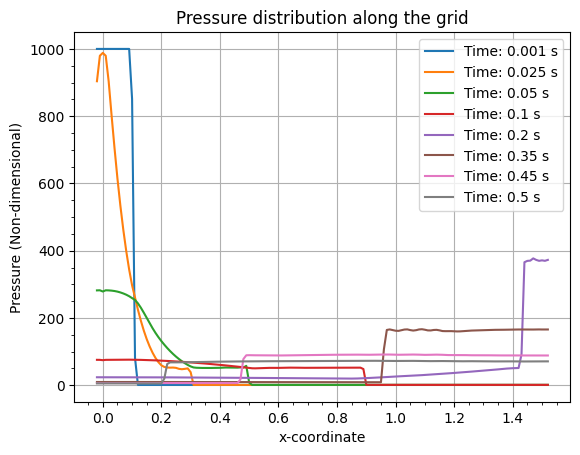

In [55]:

t_ins = [1, int(0.05*nt), int(0.1*nt), int(0.2*nt), int(0.4*nt), int(0.7*nt), int(0.9*nt), nt]
for i in range(len(t_ins)):
    a = t_ins[i]
    plt.plot(x, w_plot[a,:,2], label=f'Time: {round(time[a],5)} s')
    plt.legend()

plt.grid(True) 
plt.xlabel('x-coordinate')
plt.ylabel('Pressure (Non-dimensional)')
plt.title('Pressure distribution along the grid')
#plt.savefig('blast_pressure.png', dpi=300)
plt.minorticks_on() 


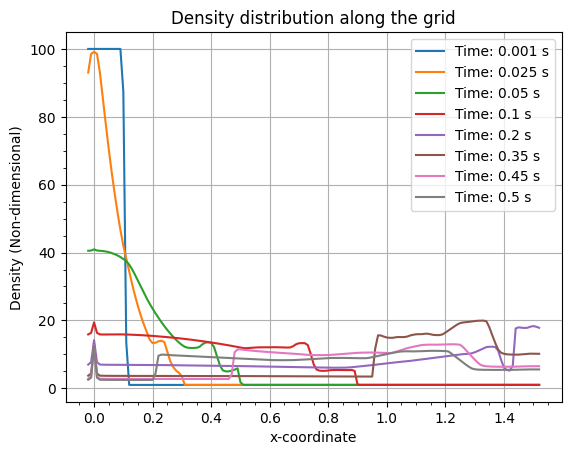

In [56]:

t_ins = [1, int(0.05*nt), int(0.1*nt), int(0.2*nt), int(0.4*nt), int(0.7*nt), int(0.9*nt), nt]
for i in range(len(t_ins)):
    a = t_ins[i]
    plt.plot(x, w_plot[a,:,0], label=f'Time: {round(time[a],5)} s')
    plt.legend()

plt.grid(True) 
plt.xlabel('x-coordinate')
plt.ylabel('Density (Non-dimensional)')
plt.title('Density distribution along the grid')
#plt.savefig('blast_density.png', dpi=300)
plt.minorticks_on() 


1
335.9920999524349
2
317.14552266092426
3
323.64506985893513
4
328.8816407639108


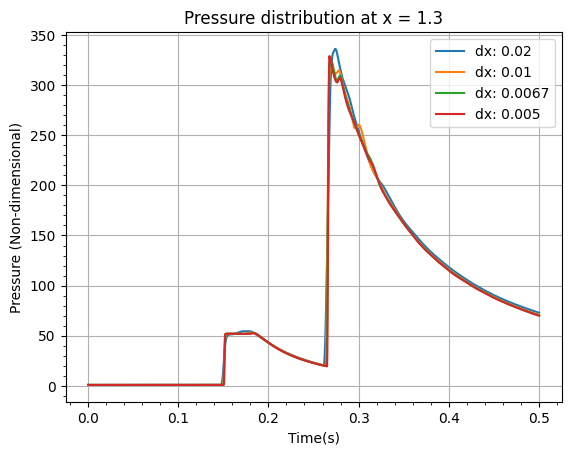

In [57]:

nt = 1500

t_f, t_i = 0.5, 0
dt = (t_f-t_i)/nt

x_f, x_i = 1.5, 0
nx_refine = [75,150,225,300]
gamma = 1.4
time = np.linspace(t_i, t_f, nt+1)
#dx = (x_f-x_i)/nx
#x = np.linspace(x_i-2*dx, x_f+2*dx, nx+5)
b = 2
#p_history = np.zeros((len(x),len(nx_refine)))
#t_history = np.zeros((len(time),len(nx_refine)))
itr = 0
p_max = []
t_hist = time[1:]
w_left = [100,0,1000]
w_right = [1,0,1]
for j in range(len(nx_refine)):
    p_hist = []
    itr+=1
    print(itr)
    dx = (x_f-x_i)/nx_refine[j]
    x = np.linspace(x_i-2*dx, x_f+2*dx, nx_refine[j]+5)
    W = np.zeros((len(x),3))
    U = np.zeros((len(x),3))
    nx = nx_refine[j]
    x_range = [x_i-2*dx,x_f+2*dx]
    lamda = dt/dx
    for i in range(len(x)):  
    
        if x[i] >=0 and x[i]<= 0.1:
            for j in range(len(w_left)):
                W[i][j] = w_left[j]
    
        if x[i] > 0.1 and x[i] <= 1.5:
            for j in range(len(w_right)):
                W[i][j] = w_right[j]

    W = ghost_add(W)
    U = conserve(U,W,gamma)
    U_pre = np.zeros((len(x), 3))
    W_pre = np.zeros_like(W)
    dW = np.zeros_like(W)
    for n,t in enumerate(time[1:]):
        #t_hist.append(t)
        Un = U.copy()
        Wn = W.copy()
        
        dW = dW_limiter(W,x,w_left,b,dW)
        
        U_pre = predictor(U,W,gamma,x,lamda,w_left,dW,U_pre)
        W_pre = primitive(U_pre,W_pre,gamma,x)
        W_pre = ghost_add(W_pre)
        W_pre = boundary_add(W_pre)
        
        U = corrector(Un,W_pre,Wn,lamda,x,dt,gamma,w_left,dW,x_range,nx)
        W = primitive(U,Wn,gamma,x)
        W = ghost_add(W)
        W = boundary_add(W)
        for i in range(len(x)):
            if x[i] == 1.3:
                p_value = W[i][2]
                p_hist.append(p_value)
    
    print(max(p_hist))
    p_max.append(max(p_hist))
    plt.plot(t_hist,p_hist, label=f'dx: {round(dx,4)}')
    plt.legend()

plt.grid(True) 
plt.xlabel('Time(s)')
plt.ylabel('Pressure (Non-dimensional)')
plt.title('Pressure distribution at x = 1.3')
#plt.savefig('pressure_hist.png', dpi=300)
plt.minorticks_on() 
    #p_history[:][j] = p_hist


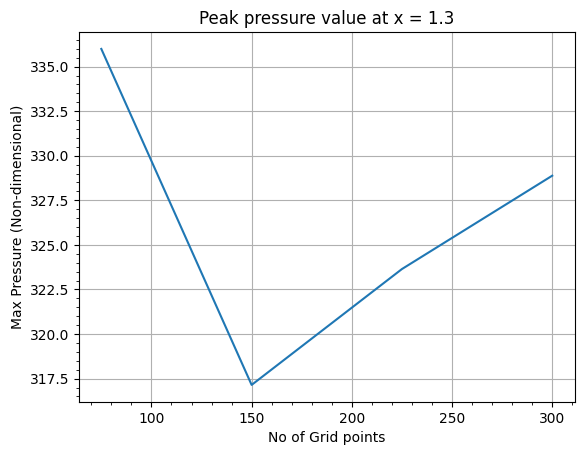

In [58]:
plt.plot(nx_refine,p_max)
plt.grid(True) 
plt.xlabel('No of Grid points')
plt.ylabel('Max Pressure (Non-dimensional)')
plt.title('Peak pressure value at x = 1.3')
#plt.savefig('pressure_peak.png', dpi=300)
plt.minorticks_on() 